# Introduction

Notebook to aggregate the running of models in the context of traceability between **features** and **bug reports**.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

from modules.models_runner import feat_br_strat_runner

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Volunteers Only Strategy

In [2]:
vol_strat_runner = feat_br_strat_runner.Feat_BR_Vol_Strat_Runner()
vol_strat_runner.execute()

evaluator_4 = vol_strat_runner.get_evaluator() 
evals_df_4 = vol_strat_runner.get_evals_df()

Feat_BR Volunteers Matrix shape: (91, 19)
Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [3]:
evals_df_4.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_1_cosine_0.1,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.1,1.0,Bug_Number 1248267 1248268 125...
2,lsi,top_1_cosine_0.2,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.2,1.0,Bug_Number 1248267 1248268 125...
3,lsi,top_1_cosine_0.3,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.3,1.0,Bug_Number 1248267 1248268 125...
4,lsi,top_1_cosine_0.4,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.4,1.0,Bug_Number 1248267 1248268 125...


In [4]:
from modules.utils import aux_functions

aux_functions.highlight_df( evals_df_4[['model','perc_precision','perc_recall','perc_fscore','top']].groupby(['model','top']).mean())

### Plots

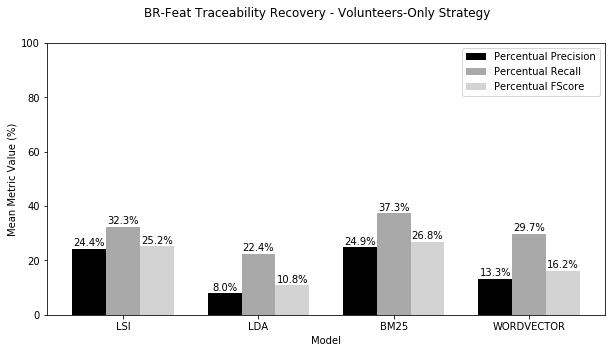

In [6]:
evaluator_4.plot_evaluations_3(evals_df_4, title='BR-Feat Traceability Recovery - Volunteers-Only Strategy')

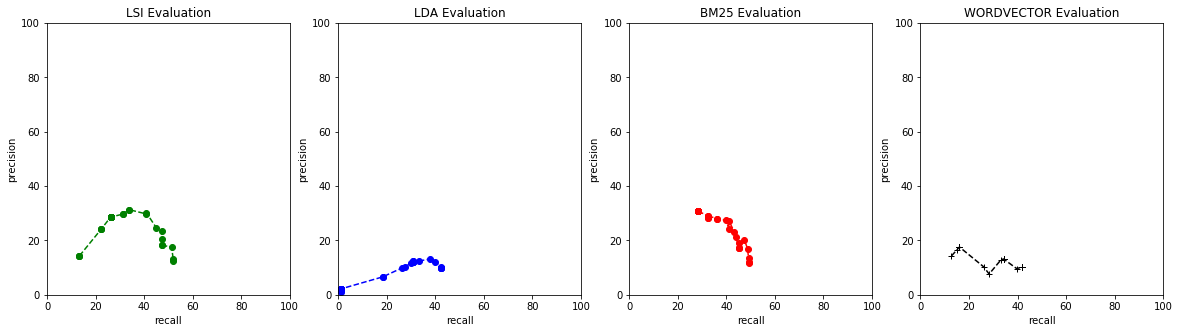

In [7]:
evaluator_4.plot_evaluations_4(evals_df_4)

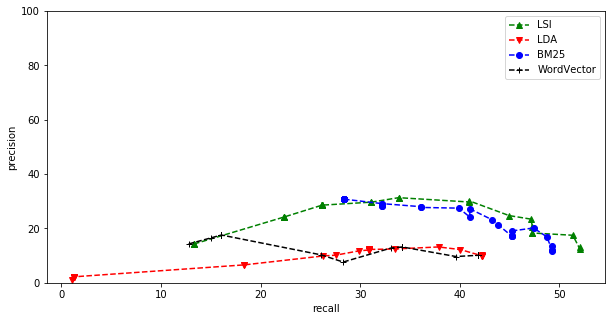

In [8]:
evaluator_4.plot_evaluations_5(evals_df_4)

### Retrieved Traces - Similarity Threshold 0.0

In [63]:
import pandas as pd

MODELS = ['lsi','lda','bm25','wordvector']
TOP_VALUES = [1,3,5]
SIM_THRESHOLDS = [0.0]

def get_retrieved_traces_df(oracle):
    retrieved_traces_df = pd.DataFrame(columns=['top','sim_thresh','model','retrieved','TP_amount','FP_amount','FN_amount','TP','FP','FN','precision','recall'])

    for m in MODELS:
        for top in TOP_VALUES:
            for sim_thresh in SIM_THRESHOLDS:
                df = evals_df_4[(evals_df_4.ref_name == 'top_{}_cosine_{}'.format(top,sim_thresh)) & (evals_df_4.model == m)].iloc[0,:]
                trace_links = df.trace_links_df

                tp = aux_functions.get_true_positives(oracle_df=oracle, output_df=trace_links)
                fp = aux_functions.get_false_positives(oracle_df=oracle, output_df=trace_links)
                fn = aux_functions.get_false_negatives(oracle_df=oracle, output_df=trace_links)

                ans = {'top': top, 
                       'sim_thresh': sim_thresh, 
                       'model': m,
                       'retrieved': sum([trace_links[col].sum() for col in trace_links.columns]),
                       'precision': df.perc_precision,
                       'recall': df.perc_recall,
                       'TP': tp,
                       'TP_amount': len(tp),
                       'FP':f p,
                       'FP_amount': len(fp),
                       'FN': fn,
                       'FN_amount': len(fn)} 

                retrieved_traces_df = retrieved_traces_df.append(ans, ignore_index=True)
    
    final_df.sort_values(by='retrieved', inplace=True)
    return final_df

retrieved_traces_df = get_retrieved_traces_df(oracle=vol_strat_runner.get_oracle())
#retrieved_traces_df.head(50)

### Oracle True Traces

In [66]:
oracle_true_traces = set()
oracle = vol_strat_runner.get_oracle()

for idx,row in oracle.iterrows():
    for col in oracle.columns:
        if oracle.at[idx, col] == 1:
            oracle_true_traces.add((idx,col))

print('len(oracle_true_traces): {}'.format(len(oracle_true_traces)))

len(oracle_true_traces): 93


### Traces Not Captured by Any Technique

In [64]:
def get_captured_traces_union(top_value):
    bm25_true_traces = retrieved_traces_df[(retrieved_traces_df.model == 'bm25') & (retrieved_traces_df.top == top_value)].iloc[0,:].TP
    lsi_true_traces = retrieved_traces_df[(retrieved_traces_df.model == 'lsi') & (retrieved_traces_df.top == top_value)].iloc[0,:].TP
    lda_true_traces = retrieved_traces_df[(retrieved_traces_df.model == 'lda') & (retrieved_traces_df.top == top_value)].iloc[0,:].TP
    wordvector_true_traces = retrieved_traces_df[(retrieved_traces_df.model == 'wordvector') & (retrieved_traces_df.top == top_value)].iloc[0,:].TP
    
    return(bm25_true_traces | lsi_true_traces | lda_true_traces | wordvector_true_traces)

print('TOP 1 --------------------------')
all_captured_traces = get_captured_traces_union(top_value=1)
not_captured_traces = oracle_true_traces - all_captured_traces
print('len(not_captured_traces): {}'.format(len(not_captured_traces)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces), len(oracle_true_traces), len(not_captured_traces)/len(oracle_true_traces)*100))

print('\n\nTOP 3 --------------------------')
all_captured_traces = get_captured_traces_union(top_value=3)
not_captured_traces = oracle_true_traces - all_captured_traces
print('len(not_captured_traces): {}'.format(len(not_captured_traces)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces), len(oracle_true_traces), len(not_captured_traces)/len(oracle_true_traces)*100))

print('\n\nTOP 5 --------------------------')
#from modules.utils import firefox_dataset_p2 as fd
all_captured_traces = get_captured_traces_union(top_value=5)
not_captured_traces = oracle_true_traces - all_captured_traces
#aux_functions.detail_features_br(not_captured_traces, features=fd.Datasets.read_features_df(), bugreports=fd.Datasets.read_selected_bugreports_df())
print('len(not_captured_traces): {}'.format(len(not_captured_traces)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces), len(oracle_true_traces), len(not_captured_traces)/len(oracle_true_traces)*100))

TOP 1 --------------------------
len(not_captured_traces): 59
percent not_captured_traces: 59/93 * 100 : 63.44%


TOP 3 --------------------------
len(not_captured_traces): 32
percent not_captured_traces: 32/93 * 100 : 34.41%


TOP 5 --------------------------
len(not_captured_traces): 23
percent not_captured_traces: 23/93 * 100 : 24.73%


### Traces Captured by Every Technique

In [65]:
def get_captured_traces_intersec(top_value):
    bm25_true_traces = retrieved_traces_df[(retrieved_traces_df.model == 'bm25') & (retrieved_traces_df.top == top_value)].iloc[0,:].TP
    lsi_true_traces = retrieved_traces_df[(retrieved_traces_df.model == 'lsi') & (retrieved_traces_df.top == top_value)].iloc[0,:].TP
    lda_true_traces = retrieved_traces_df[(retrieved_traces_df.model == 'lda') & (retrieved_traces_df.top == top_value)].iloc[0,:].TP
    wordvector_true_traces = retrieved_traces_df[(retrieved_traces_df.model == 'wordvector') & (retrieved_traces_df.top == top_value)].iloc[0,:].TP
    
    return(bm25_true_traces & lsi_true_traces & lda_true_traces & wordvector_true_traces)

print('TOP 1 -----------------------')
traces_captured_by_all = get_captured_traces_intersec(1)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all), len(oracle_true_traces), len(traces_captured_by_all)/len(oracle_true_traces) *100))

print('\n\nTOP 3 -----------------------')
traces_captured_by_all = get_captured_traces_intersec(3)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all), len(oracle_true_traces), len(traces_captured_by_all)/len(oracle_true_traces) *100))

print('\n\nTOP 5 -----------------------')
traces_captured_by_all = get_captured_traces_intersec(5)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all), len(oracle_true_traces), len(traces_captured_by_all)/len(oracle_true_traces) *100))

TOP 1 -----------------------
len(traces_captured_by_all): 0
percent traces_captured_by_all: 0/93 * 100 : 0.0%


TOP 3 -----------------------
len(traces_captured_by_all): 24
percent traces_captured_by_all: 24/93 * 100 : 25.81%


TOP 5 -----------------------
len(traces_captured_by_all): 34
percent traces_captured_by_all: 34/93 * 100 : 36.56%


### Delete Variables

## Union Strategy

In [ ]:
exp_vol_union_strat_runner = feat_br_strat_runner.Feat_BR_Exp_Vol_Union_Strat_Runner()
exp_vol_union_strat_runner.execute()

evaluator_1 = exp_vol_union_strat_runner.get_evaluator() 
evals_df_1 = exp_vol_union_strat_runner.get_evals_df()

### Results

In [ ]:
evals_df_1.head()

In [ ]:
evaluator_1.plot_evaluations_4(evals_df_1)

In [ ]:
evaluator_1.plot_evaluations_5(evals_df_1)

### Plots

In [ ]:
evaluator_1.plot_evaluations_3(evals_df_1, title='BR-Feat Traceability Recovery - Exp-Vol Union Strategy')

### Delete Variables

## Intersec Strategy

In [67]:
exp_vol_intersec_strat_runner = feat_br_strat_runner.Feat_BR_Exp_Vol_Intersec_Strat_Runner()
exp_vol_intersec_strat_runner.execute()

evaluator_2 = exp_vol_intersec_strat_runner.get_evaluator() 
evals_df_2 = exp_vol_intersec_strat_runner.get_evals_df()

Expert and Volunteers Matrix INTERSEC.shape: (91, 19)
Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [68]:
evals_df_2.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,26.37,25.82,26.01,precision recall fscore Bug_Number 1248267 1.0 1.0 1.000000 1248268 0.0 0.0 0.000000 1257087 0.0 0.0 0.000000 1264988 1.0 1.0 1.000000 1267480 0.0 0.0 0.000000 1267501 0.0 0.0 0.000000 1269348 0.0 0.0 0.000000 1269485 0.0 0.0 0.000...,0.0,1.0,Bug_Number 1248267 1248268 1257087 1264988 1267480 1267501 \ feat_name new_awesome_bar 0 1 1 1 0 1 windows_child_mode 0 0 0 0 0 0 apz_async_scrolling 0 0 0 0 0 ...
1,lsi,top_1_cosine_0.1,26.37,25.82,26.01,precision recall fscore Bug_Number 1248267 1.0 1.0 1.000000 1248268 0.0 0.0 0.000000 1257087 0.0 0.0 0.000000 1264988 1.0 1.0 1.000000 1267480 0.0 0.0 0.000000 1267501 0.0 0.0 0.000000 1269348 0.0 0.0 0.000000 1269485 0.0 0.0 0.000...,0.1,1.0,Bug_Number 1248267 1248268 1257087 1264988 1267480 1267501 \ feat_name new_awesome_bar 0 1 1 1 0 1 windows_child_mode 0 0 0 0 0 0 apz_async_scrolling 0 0 0 0 0 ...
2,lsi,top_1_cosine_0.2,26.37,25.82,26.01,precision recall fscore Bug_Number 1248267 1.0 1.0 1.000000 1248268 0.0 0.0 0.000000 1257087 0.0 0.0 0.000000 1264988 1.0 1.0 1.000000 1267480 0.0 0.0 0.000000 1267501 0.0 0.0 0.000000 1269348 0.0 0.0 0.000000 1269485 0.0 0.0 0.000...,0.2,1.0,Bug_Number 1248267 1248268 1257087 1264988 1267480 1267501 \ feat_name new_awesome_bar 0 1 1 1 0 1 windows_child_mode 0 0 0 0 0 0 apz_async_scrolling 0 0 0 0 0 ...
3,lsi,top_1_cosine_0.3,26.37,25.82,26.01,precision recall fscore Bug_Number 1248267 1.0 1.0 1.000000 1248268 0.0 0.0 0.000000 1257087 0.0 0.0 0.000000 1264988 1.0 1.0 1.000000 1267480 0.0 0.0 0.000000 1267501 0.0 0.0 0.000000 1269348 0.0 0.0 0.000000 1269485 0.0 0.0 0.000...,0.3,1.0,Bug_Number 1248267 1248268 1257087 1264988 1267480 1267501 \ feat_name new_awesome_bar 0 1 1 1 0 1 windows_child_mode 0 0 0 0 0 0 apz_async_scrolling 0 0 0 0 0 ...
4,lsi,top_1_cosine_0.4,26.37,25.82,26.01,precision recall fscore Bug_Number 1248267 1.0 1.0 1.000000 1248268 0.0 0.0 0.000000 1257087 0.0 0.0 0.000000 1264988 1.0 1.0 1.000000 1267480 0.0 0.0 0.000000 1267501 0.0 0.0 0.000000 1269348 0.0 0.0 0.000000 1269485 0.0 0.0 0.000...,0.4,1.0,Bug_Number 1248267 1248268 1257087 1264988 1267480 1267501 \ feat_name new_awesome_bar 0 1 1 1 0 1 windows_child_mode 0 0 0 0 0 0 apz_async_scrolling 0 0 0 0 0 ...


### Plots

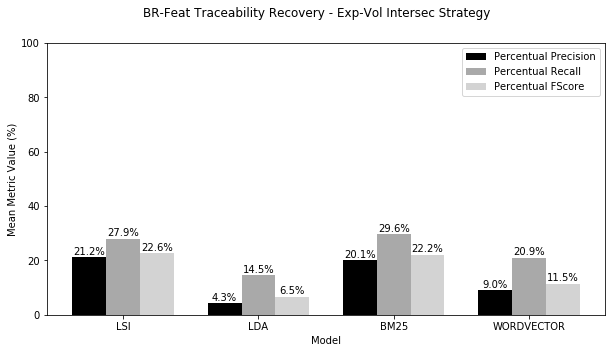

In [69]:
evaluator_2.plot_evaluations_3(evals_df_2, title='BR-Feat Traceability Recovery - Exp-Vol Intersec Strategy')

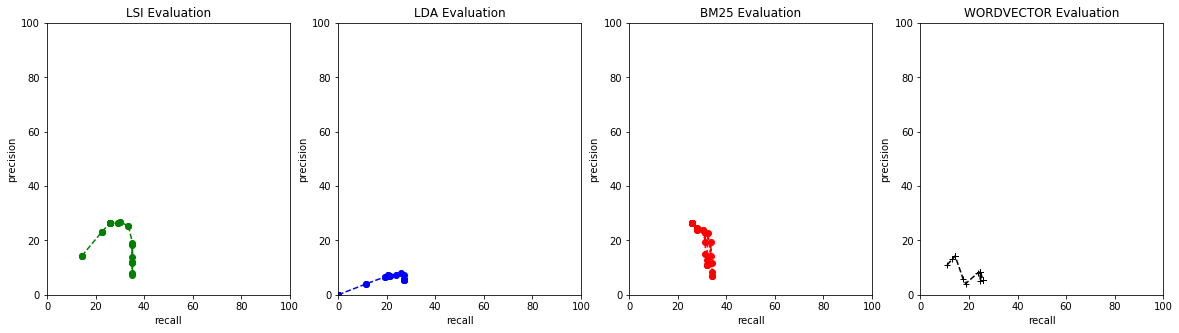

In [70]:
evaluator_2.plot_evaluations_4(evals_df_2)

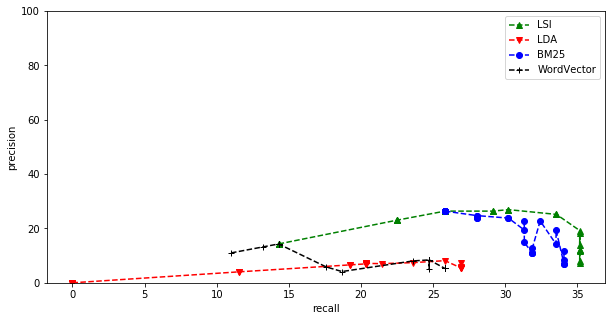

In [71]:
evaluator_2.plot_evaluations_5(evals_df_2)

### Retrieved Traces - Similarity Threshold 0.0

In [78]:
retrieved_traces_df = get_retrieved_traces_df(oracle=exp_vol_intersec_strat_runner.get_oracle())
retrieved_traces_df[['top','sim_thresh','model','TP_amount','FP_amount','FN_amount','precision','recall']].head(50)

,top,sim_thresh,model,TP_amount,FP_amount,FN_amount,precision,recall
0,1,0.0,lsi,26,65,67,28.57,26.18
3,1,0.0,lda,2,89,91,2.20,1.24
6,1,0.0,bm25,28,63,65,30.77,28.38
9,1,0.0,wordvector,16,75,77,17.58,16.07
1,3,0.0,lsi,50,223,43,18.32,47.31
4,3,0.0,lda,33,240,60,12.09,30.93
7,3,0.0,bm25,47,226,46,17.22,45.22
10,3,0.0,wordvector,36,237,57,13.19,34.23
2,5,0.0,lsi,57,398,36,12.53,52.06
5,5,0.0,lda,45,410,48,9.89,42.28


### Oracle True Traces

In [74]:
oracle_true_traces = set()
oracle = exp_vol_intersec_strat_runner.get_oracle()

for idx,row in oracle.iterrows():
    for col in oracle.columns:
        if oracle.at[idx, col] == 1:
            oracle_true_traces.add((idx,col))

print('len(oracle_true_traces): {}'.format(len(oracle_true_traces)))

len(oracle_true_traces): 34


### Traces Not Captured by Any Technique

In [75]:
print('TOP 1 --------------------------')
all_captured_traces = get_captured_traces_union(top_value=1)
not_captured_traces = oracle_true_traces - all_captured_traces
print('len(not_captured_traces): {}'.format(len(not_captured_traces)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces), len(oracle_true_traces), len(not_captured_traces)/len(oracle_true_traces)*100))

print('\n\nTOP 3 --------------------------')
all_captured_traces = get_captured_traces_union(top_value=3)
not_captured_traces = oracle_true_traces - all_captured_traces
print('len(not_captured_traces): {}'.format(len(not_captured_traces)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces), len(oracle_true_traces), len(not_captured_traces)/len(oracle_true_traces)*100))

print('\n\nTOP 5 --------------------------')
#from modules.utils import firefox_dataset_p2 as fd
all_captured_traces = get_captured_traces_union(top_value=5)
not_captured_traces = oracle_true_traces - all_captured_traces
#aux_functions.detail_features_br(not_captured_traces, features=fd.Datasets.read_features_df(), bugreports=fd.Datasets.read_selected_bugreports_df())
print('len(not_captured_traces): {}'.format(len(not_captured_traces)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces), len(oracle_true_traces), len(not_captured_traces)/len(oracle_true_traces)*100))

TOP 1 --------------------------
len(not_captured_traces): 7
percent not_captured_traces: 7/34 * 100 : 20.59%


TOP 3 --------------------------
len(not_captured_traces): 0
percent not_captured_traces: 0/34 * 100 : 0.0%


TOP 5 --------------------------
len(not_captured_traces): 0
percent not_captured_traces: 0/34 * 100 : 0.0%


### Traces Captured by Every Technique

In [76]:
print('TOP 1 -----------------------')
traces_captured_by_all = get_captured_traces_intersec(1)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all), len(oracle_true_traces), len(traces_captured_by_all)/len(oracle_true_traces) *100))

print('\n\nTOP 3 -----------------------')
traces_captured_by_all = get_captured_traces_intersec(3)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all), len(oracle_true_traces), len(traces_captured_by_all)/len(oracle_true_traces) *100))

print('\n\nTOP 5 -----------------------')
traces_captured_by_all = get_captured_traces_intersec(5)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all), len(oracle_true_traces), len(traces_captured_by_all)/len(oracle_true_traces) *100))

TOP 1 -----------------------
len(traces_captured_by_all): 0
percent traces_captured_by_all: 0/34 * 100 : 0.0%


TOP 3 -----------------------
len(traces_captured_by_all): 24
percent traces_captured_by_all: 24/34 * 100 : 70.59%


TOP 5 -----------------------
len(traces_captured_by_all): 34
percent traces_captured_by_all: 34/34 * 100 : 100.0%


### True Positives Analysis - TOP 5

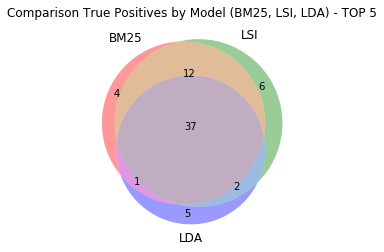

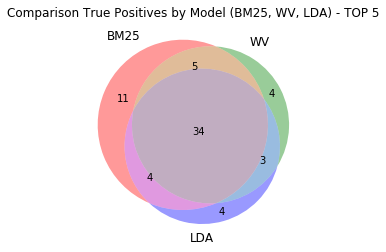

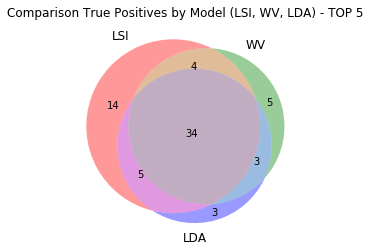

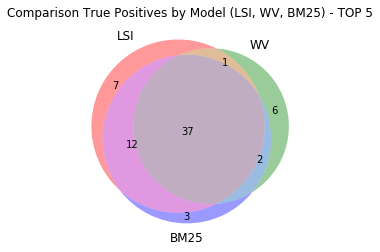

In [82]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

bm25_tp_set = retrieved_traces_df[(retrieved_traces_df.model == 'bm25') & (retrieved_traces_df.top == 5)].iloc[0,:].TP
lsi_tp_set = retrieved_traces_df[(retrieved_traces_df.model == 'lsi') & (retrieved_traces_df.top == 5)].iloc[0,:].TP
lda_tp_set = retrieved_traces_df[(retrieved_traces_df.model == 'lda') & (retrieved_traces_df.top == 5)].iloc[0,:].TP
wv_tp_set = retrieved_traces_df[(retrieved_traces_df.model == 'wordvector') & (retrieved_traces_df.top == 5)].iloc[0,:].TP

venn3([bm25_tp_set, lsi_tp_set, lda_tp_set], ['BM25','LSI','LDA'])
plt.title('Comparison True Positives by Model (BM25, LSI, LDA) - TOP 5')
plt.show()

venn3([bm25_tp_set, wv_tp_set, lda_tp_set], ['BM25','WV','LDA'])
plt.title('Comparison True Positives by Model (BM25, WV, LDA) - TOP 5')
plt.show()

venn3([lsi_tp_set, wv_tp_set, lda_tp_set], ['LSI','WV','LDA'])
plt.title('Comparison True Positives by Model (LSI, WV, LDA) - TOP 5')
plt.show()

venn3([lsi_tp_set, wv_tp_set, bm25_tp_set], ['LSI','WV','BM25'])
plt.title('Comparison True Positives by Model (LSI, WV, BM25) - TOP 5')
plt.show()

### False Positives Analysis - TOP 5

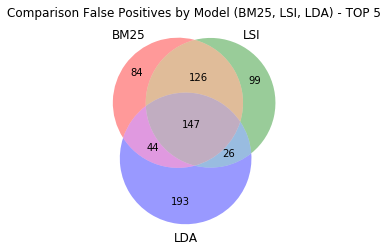

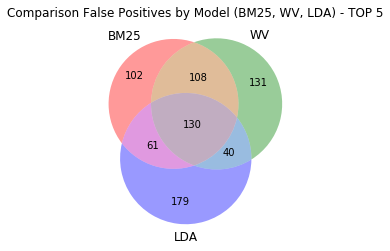

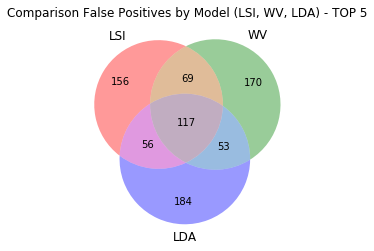

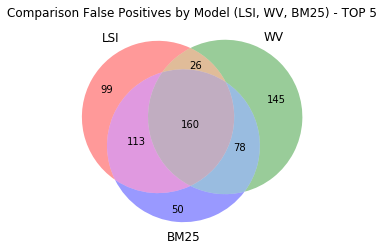

In [85]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

bm25_fp_set = retrieved_traces_df[(retrieved_traces_df.model == 'bm25') & (retrieved_traces_df.top == 5)].iloc[0,:].FP
lsi_fp_set = retrieved_traces_df[(retrieved_traces_df.model == 'lsi') & (retrieved_traces_df.top == 5)].iloc[0,:].FP
lda_fp_set = retrieved_traces_df[(retrieved_traces_df.model == 'lda') & (retrieved_traces_df.top == 5)].iloc[0,:].FP
wv_fp_set = retrieved_traces_df[(retrieved_traces_df.model == 'wordvector') & (retrieved_traces_df.top == 5)].iloc[0,:].FP

venn3([bm25_fp_set, lsi_fp_set, lda_fp_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Positives by Model (BM25, LSI, LDA) - TOP 5')
plt.show()

venn3([bm25_fp_set, wv_fp_set, lda_fp_set], ['BM25','WV','LDA'])
plt.title('Comparison False Positives by Model (BM25, WV, LDA) - TOP 5')
plt.show()

venn3([lsi_fp_set, wv_fp_set, lda_fp_set], ['LSI','WV','LDA'])
plt.title('Comparison False Positives by Model (LSI, WV, LDA) - TOP 5')
plt.show()

venn3([lsi_fp_set, wv_fp_set, bm25_fp_set], ['LSI','WV','BM25'])
plt.title('Comparison False Positives by Model (LSI, WV, BM25) - TOP 5')
plt.show()

### False Negatives Analysis - TOP 5

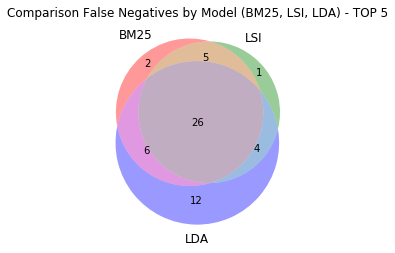

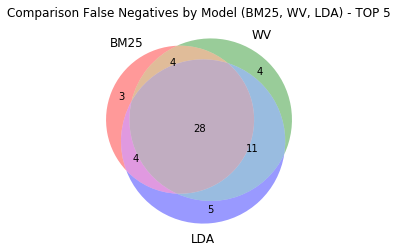

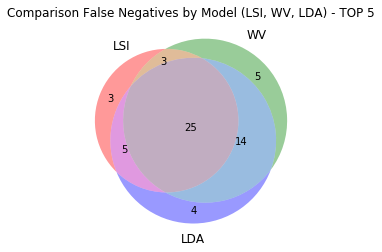

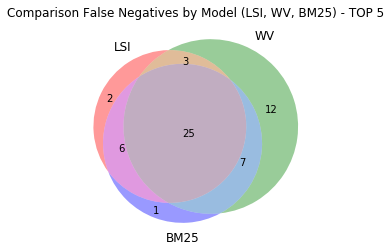

In [86]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

bm25_fn_set = retrieved_traces_df[(retrieved_traces_df.model == 'bm25') & (retrieved_traces_df.top == 5)].iloc[0,:].FN
lsi_fn_set = retrieved_traces_df[(retrieved_traces_df.model == 'lsi') & (retrieved_traces_df.top == 5)].iloc[0,:].FN
lda_fn_set = retrieved_traces_df[(retrieved_traces_df.model == 'lda') & (retrieved_traces_df.top == 5)].iloc[0,:].FN
wv_fn_set = retrieved_traces_df[(retrieved_traces_df.model == 'wordvector') & (retrieved_traces_df.top == 5)].iloc[0,:].FN

venn3([bm25_fn_set, lsi_fn_set, lda_fn_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Negatives by Model (BM25, LSI, LDA) - TOP 5')
plt.show()

venn3([bm25_fn_set, wv_fn_set, lda_fn_set], ['BM25','WV','LDA'])
plt.title('Comparison False Negatives by Model (BM25, WV, LDA) - TOP 5')
plt.show()

venn3([lsi_fn_set, wv_fn_set, lda_fn_set], ['LSI','WV','LDA'])
plt.title('Comparison False Negatives by Model (LSI, WV, LDA) - TOP 5')
plt.show()

venn3([lsi_fn_set, wv_fn_set, bm25_fn_set], ['LSI','WV','BM25'])
plt.title('Comparison False Negatives by Model (LSI, WV, BM25) - TOP 5')
plt.show()

### Delete Variables

## Expert Only Strategy

In [ ]:
exp_strat_runner = feat_br_strat_runner.Feat_BR_Exp_Strat_Runner()
exp_strat_runner.execute()

evaluator_3 = exp_strat_runner.get_evaluator() 
evals_df_3 = exp_strat_runner.get_evals_df()

### Results

In [ ]:
evals_df_3.head()

### Plots

In [ ]:
evaluator_3.plot_evaluations_3(evals_df_3, title='BR-Feat Traceability Recovery - Expert-Only Strategy')

In [ ]:
evaluator_3.plot_evaluations_4(evals_df_3)

In [ ]:
evaluator_3.plot_evaluations_5(evals_df_3)

### Delete Variables